<a href="https://colab.research.google.com/github/INFJakZda/Emotion-Recognition/blob/master/reports/Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importowanie bibliotek

In [2]:
import argparse
import io
import json
import os
import re
import numpy as np
from matplotlib import pyplot as plt

from pylab import rcParams

import tensorflow as tf
print(tf.__version__)

from keras import optimizers
from keras.layers import Dense, Embedding, LSTM, Bidirectional
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical


2.3.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Funkcje pomocnicze

## Definicja stałych

In [4]:
EMBEDDING_DIM=100
LSTM_DIM=120
NUM_CLASSES=4
MAX_SEQUENCE_LENGTH=200
DROPOUT=0.2
LEARNING_RATE=0.003
NUM_FOLDS=5
MAX_NB_WORDS=20000
BATCH_SIZE=200
NUM_EPOCHS=100

## Funkcje

In [7]:
def getOneLayerLSTM(embeddingMatrix):
    """Constructs the architecture of the model
    Input:
        embeddingMatrix : The embedding matrix to be loaded in the embedding layer.
    Output:
        model : A basic LSTM model
    """
    embeddingLayer = Embedding(embeddingMatrix.shape[0],
                               EMBEDDING_DIM,
                               weights=[embeddingMatrix],
                               input_length=MAX_SEQUENCE_LENGTH,
                               trainable=False)
    model = Sequential()
    model.add(embeddingLayer)
    model.add(LSTM(LSTM_DIM, dropout=DROPOUT))
    model.add(Dense(NUM_CLASSES, activation='sigmoid'))

    rmsprop = tf.keras.optimizers.RMSprop(lr=LEARNING_RATE)
    model.compile(loss='categorical_crossentropy',
                  optimizer=rmsprop,
                  metrics=['acc'])
    return model

In [8]:
def getDeepLSTM(embeddingMatrix):
    """Constructs the architecture of the model
    Input:
        embeddingMatrix : The embedding matrix to be loaded in the embedding layer.
    Output:
        model : A basic LSTM model
    """
    embeddingLayer = Embedding(embeddingMatrix.shape[0],
                               EMBEDDING_DIM,
                               weights=[embeddingMatrix],
                               input_length=MAX_SEQUENCE_LENGTH,
                               trainable=False)
    model = Sequential()
    model.add(embeddingLayer)
    model.add(Bidirectional(LSTM(LSTM_DIM, dropout=DROPOUT, return_sequences=True)))
    model.add(Bidirectional(LSTM(LSTM_DIM, dropout=DROPOUT, return_sequences=True)))
    model.add(Bidirectional(LSTM(LSTM_DIM)))
    model.add(Dense(LSTM_DIM, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(NUM_CLASSES, activation='softmax'))

    rmsprop = tf.keras.optimizers.RMSprop(lr=LEARNING_RATE)
    model.compile(loss='categorical_crossentropy',
                  optimizer=rmsprop,
                  metrics=['acc'])
    return model

In [9]:
def preprocessData(dataFilePath, mode, eos=" <eos> "):
    """Load data from a file, process and return indices, conversations and labels in separate lists
    Input:
        dataFilePath : Path to train/test file to be processed
        mode : "train" mode returns labels. "test" mode doesn't return labels.
    Output:
        indices : Unique conversation ID list
        conversations : List of 3 turn conversations, processed and each turn separated by the <eos> tag
        labels : [Only available in "train" mode] List of labels
    """
    indices = []
    conversations = []
    labels = []
    with io.open(dataFilePath, encoding="utf8") as finput:
        finput.readline()
        for line in finput:
            # Convert multiple instances of . ? ! , to single instance
            # okay...sure -> okay . sure
            # okay???sure -> okay ? sure
            # Add whitespace around such punctuation
            # okay!sure -> okay ! sure
            repeatedChars = ['.', '?', '!', ',']
            for c in repeatedChars:
                lineSplit = line.split(c)
                while True:
                    try:
                        lineSplit.remove('')
                    except:
                        break
                cSpace = ' ' + c + ' '
                line = cSpace.join(lineSplit)

            line = line.strip().split('\t')
            if mode == "train":
                # Train data contains id, 3 turns and label
                label = emotion2label[line[4]]
                labels.append(label)

            conv = f'{eos}'.join(line[1:4])

            # Remove any duplicate spaces
            duplicateSpacePattern = re.compile(r'\ +')
            conv = re.sub(duplicateSpacePattern, ' ', conv)

            indices.append(int(line[0]))
            conversations.append(conv.lower())

    if mode == "train":
        return indices, conversations, labels
    else:
        return indices, conversations

In [10]:
def getMetrics(predictions, ground):
    """Given predicted labels and the respective ground truth labels, display some metrics
    Input: shape [# of samples, NUM_CLASSES]
        predictions : Model output. Every row has 4 decimal values, with the highest belonging to the predicted class
        ground : Ground truth labels, converted to one-hot encodings. A sample belonging to Happy class will be [0, 1, 0, 0]
    Output:
        accuracy : Average accuracy
        microPrecision : Precision calculated on a micro level. Ref - https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin/16001
        microRecall : Recall calculated on a micro level
        microF1 : Harmonic mean of microPrecision and microRecall. Higher value implies better classification  
    """
    # [0.1, 0.3 , 0.2, 0.1] -> [0, 1, 0, 0]
    discretePredictions = to_categorical(predictions.argmax(axis=1))

    truePositives = np.sum(discretePredictions * ground, axis=0)
    falsePositives = np.sum(np.clip(discretePredictions - ground, 0, 1), axis=0)
    falseNegatives = np.sum(np.clip(ground - discretePredictions, 0, 1), axis=0)

    print("True Positives per class : ", truePositives)
    print("False Positives per class : ", falsePositives)
    print("False Negatives per class : ", falseNegatives)

    # ------------- Macro level calculation ---------------
    macroPrecision = 0
    macroRecall = 0
    # We ignore the "Others" class during the calculation of Precision, Recall and F1
    for c in range(1, NUM_CLASSES):
        precision = truePositives[c] / (truePositives[c] + falsePositives[c])
        macroPrecision += precision
        recall = truePositives[c] / (truePositives[c] + falseNegatives[c])
        macroRecall += recall
        f1 = (2 * recall * precision) / (precision + recall) if (precision + recall) > 0 else 0
        print("Class %s : Precision : %.3f, Recall : %.3f, F1 : %.3f" % (label2emotion[c], precision, recall, f1))

    macroPrecision /= 3
    macroRecall /= 3
    macroF1 = (2 * macroRecall * macroPrecision) / (macroPrecision + macroRecall) if (
                                                                                             macroPrecision + macroRecall) > 0 else 0
    print("Ignoring the Others class, Macro Precision : %.4f, Macro Recall : %.4f, Macro F1 : %.4f" % (
        macroPrecision, macroRecall, macroF1))

    # ------------- Micro level calculation ---------------
    truePositives = truePositives[1:].sum()
    falsePositives = falsePositives[1:].sum()
    falseNegatives = falseNegatives[1:].sum()

    print(
        "Ignoring the Others class, Micro TP : %d, FP : %d, FN : %d" % (truePositives, falsePositives, falseNegatives))

    microPrecision = truePositives / (truePositives + falsePositives)
    microRecall = truePositives / (truePositives + falseNegatives)

    microF1 = (2 * microRecall * microPrecision) / (microPrecision + microRecall) if (
                                                                                             microPrecision + microRecall) > 0 else 0
    # -----------------------------------------------------

    predictions = predictions.argmax(axis=1)
    ground = ground.argmax(axis=1)
    accuracy = np.mean(predictions == ground)

    print("Accuracy : %.4f, Micro Precision : %.4f, Micro Recall : %.4f, Micro F1 : %.4f" % (
        accuracy, microPrecision, microRecall, microF1))
    return accuracy, microPrecision, microRecall, microF1

In [11]:
def getEmbeddingMatrix(wordIndex):
    """Populate an embedding matrix using a word-index. If the word "happy" has an index 19,
       the 19th row in the embedding matrix should contain the embedding vector for the word "happy".
    Input:
        wordIndex : A dictionary of (word : index) pairs, extracted using a tokeniser
    Output:
        embeddingMatrix : A matrix where every row has 100 dimensional GloVe embedding
    """
    embeddingsIndex = {}
    # Load the embedding vectors from ther GloVe file
    with io.open(gloveDir, encoding="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            embeddingVector = np.asarray(values[1:], dtype='float32')
            embeddingsIndex[word] = embeddingVector

    print('Found %s word vectors.' % len(embeddingsIndex))

    # Minimum word index of any word is 1. 
    embeddingMatrix = np.zeros((len(wordIndex) + 1, EMBEDDING_DIM))
    for word, i in wordIndex.items():
        embeddingVector = embeddingsIndex.get(word)
        if embeddingVector is not None:
            # words not found in embedding index will be all-zeros.
            embeddingMatrix[i] = embeddingVector

    return embeddingMatrix

# Kod wykonawczy

In [12]:
mainPath = '/content/drive/My Drive/Magisterka/'

trainDataPath = mainPath + 'train.txt'
devDataPath = mainPath + 'test.txt'
testDataPath = mainPath + 'test.txt'

solutionPath = mainPath + 'solution/'

gloveDir = mainPath + 'glove.6B.100d.txt'

label2emotion = {0: "others", 1: "happy", 2: "sad", 3: "angry"}
emotion2label = {"others": 0, "happy": 1, "sad": 2, "angry": 3}

## Przetwarzanie danych

In [13]:
trainIndices, trainTexts, trainLabels = preprocessData(trainDataPath, mode="train")
devIndices, devTexts, devLabels = preprocessData(devDataPath, mode="train")
testIndices, testTexts, testLabels = preprocessData(testDataPath, mode="train")

In [14]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(trainTexts)

trainSequences = tokenizer.texts_to_sequences(trainTexts)
devSequences = tokenizer.texts_to_sequences(devTexts)
testSequences = tokenizer.texts_to_sequences(testTexts)

In [15]:
wordIndex = tokenizer.word_index
embeddingMatrix = getEmbeddingMatrix(wordIndex)

Found 400000 word vectors.


In [16]:
dataTrain = pad_sequences(trainSequences, maxlen=MAX_SEQUENCE_LENGTH)
dataDev = pad_sequences(devSequences, maxlen=MAX_SEQUENCE_LENGTH)
dataTest = pad_sequences(testSequences, maxlen=MAX_SEQUENCE_LENGTH)

trainLabels = to_categorical(np.asarray(trainLabels))
devLabels = to_categorical(np.asarray(devLabels))
testLabels = to_categorical(np.asarray(testLabels))

## Budowa i ewaluacja modeli

### Jednowarstwowy LSTM

In [17]:
model = getOneLayerLSTM(embeddingMatrix)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 100)          1683200   
_________________________________________________________________
lstm (LSTM)                  (None, 120)               106080    
_________________________________________________________________
dense (Dense)                (None, 4)                 484       
Total params: 1,789,764
Trainable params: 106,564
Non-trainable params: 1,683,200
_________________________________________________________________


In [18]:
history = model.fit(dataTrain, trainLabels, validation_data=(dataDev, devLabels), epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)
model.save(mainPath + 'EP%d_LR%de-5_LDim%d_BS%d.h5' % (NUM_EPOCHS, int(LEARNING_RATE * (10 ** 5)), LSTM_DIM, BATCH_SIZE))

Epoch 1/100
151/151 [==============================] - 10s 66ms/step - loss: 0.8679 - acc: 0.6491 - val_loss: 0.5086 - val_acc: 0.8067
Epoch 2/100
151/151 [==============================] - 9s 62ms/step - loss: 0.6003 - acc: 0.7677 - val_loss: 0.3874 - val_acc: 0.8640
Epoch 3/100
151/151 [==============================] - 9s 61ms/step - loss: 0.5137 - acc: 0.8058 - val_loss: 0.3497 - val_acc: 0.8766
Epoch 4/100
151/151 [==============================] - 9s 62ms/step - loss: 0.4518 - acc: 0.8293 - val_loss: 0.4391 - val_acc: 0.8461
Epoch 5/100
151/151 [==============================] - 9s 62ms/step - loss: 0.4131 - acc: 0.8463 - val_loss: 0.4484 - val_acc: 0.8308
Epoch 6/100
151/151 [==============================] - 9s 62ms/step - loss: 0.3834 - acc: 0.8556 - val_loss: 0.3229 - val_acc: 0.8913
Epoch 7/100
151/151 [==============================] - 9s 62ms/step - loss: 0.3693 - acc: 0.8607 - val_loss: 0.4034 - val_acc: 0.8584
Epoch 8/100
151/151 [==============================] - 9s 61m

In [ ]:
rcParams['figure.figsize'] = 8,6
plt.plot(history.history['acc'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='lower right')
plt.show()

In [ ]:
rcParams['figure.figsize'] = 8,6
plt.plot(history.history['loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='right')
plt.show()

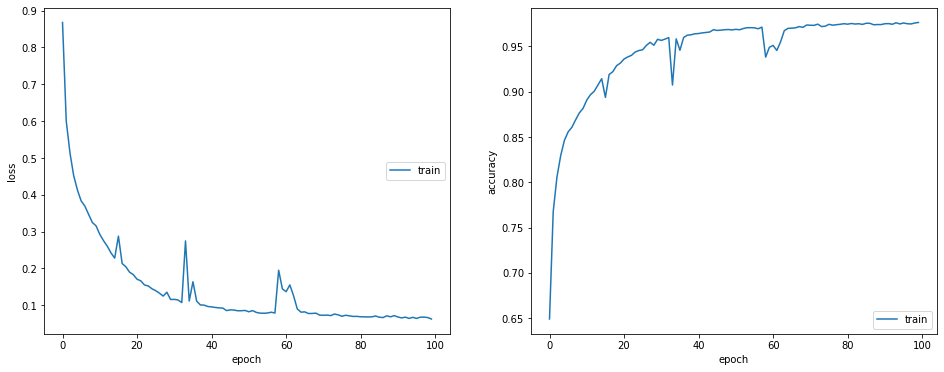

In [19]:
rcParams['figure.figsize'] = 16, 6

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(history.history['loss'])
ax1.set(xlabel='epoch', ylabel='loss')
ax1.legend(['train'], loc='right')
ax2.plot(history.history['acc'])
ax2.set(xlabel='epoch', ylabel='accuracy')
ax2.legend(['train'], loc='lower right')

In [20]:
predictions = model.predict(dataTest, batch_size=BATCH_SIZE)
accuracy, microPrecision, microRecall, microF1 = getMetrics(predictions, testLabels)

True Positives per class :  [4146.  182.  173.  234.]
False Positives per class :  [180. 184. 238. 172.]
False Negatives per class :  [531. 102.  77.  64.]
Class happy : Precision : 0.497, Recall : 0.641, F1 : 0.560
Class sad : Precision : 0.421, Recall : 0.692, F1 : 0.523
Class angry : Precision : 0.576, Recall : 0.785, F1 : 0.665
Ignoring the Others class, Macro Precision : 0.4982, Macro Recall : 0.7060, Macro F1 : 0.5842
Ignoring the Others class, Micro TP : 589, FP : 594, FN : 243
Accuracy : 0.8595, Micro Precision : 0.4979, Micro Recall : 0.7079, Micro F1 : 0.5846


### Głęboki LSTM

In [21]:
modelDeep = getDeepLSTM(embeddingMatrix)

modelDeep.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 100)          1683200   
_________________________________________________________________
bidirectional (Bidirectional (None, 200, 240)          212160    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 240)          346560    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 240)               346560    
_________________________________________________________________
dense_1 (Dense)              (None, 120)               28920     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                7744      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                

In [22]:
historyDeep = modelDeep.fit(dataTrain, trainLabels, validation_data=(dataDev, devLabels), epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)
modelDeep.save(mainPath + 'EP%d_LR%de-5_LDim%d_BS%d_DEEP.h5' % (NUM_EPOCHS, int(LEARNING_RATE * (10 ** 5)), LSTM_DIM, BATCH_SIZE))

Epoch 1/100
151/151 [==============================] - 66s 437ms/step - loss: 1.0858 - acc: 0.5552 - val_loss: 0.4142 - val_acc: 0.8622
Epoch 2/100
151/151 [==============================] - 64s 423ms/step - loss: 0.6941 - acc: 0.7359 - val_loss: 0.4905 - val_acc: 0.8248
Epoch 3/100
151/151 [==============================] - 64s 425ms/step - loss: 0.5512 - acc: 0.7928 - val_loss: 0.4399 - val_acc: 0.8441
Epoch 4/100
151/151 [==============================] - 64s 424ms/step - loss: 0.4699 - acc: 0.8237 - val_loss: 0.4869 - val_acc: 0.8103
Epoch 5/100
151/151 [==============================] - 64s 422ms/step - loss: 0.4130 - acc: 0.8475 - val_loss: 0.4484 - val_acc: 0.8375
Epoch 6/100
151/151 [==============================] - 64s 424ms/step - loss: 0.3778 - acc: 0.8600 - val_loss: 0.3477 - val_acc: 0.8816
Epoch 7/100
151/151 [==============================] - 64s 424ms/step - loss: 0.3406 - acc: 0.8721 - val_loss: 0.3662 - val_acc: 0.8811
Epoch 8/100
151/151 [===========================

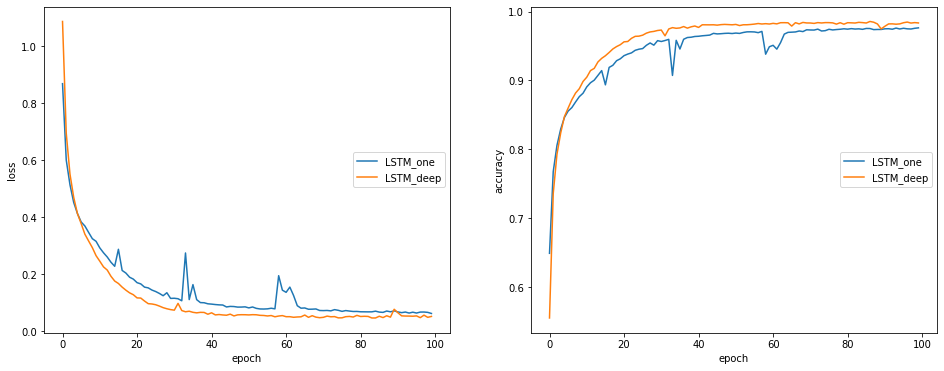

In [25]:
rcParams['figure.figsize'] = 16, 6

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(history.history['loss'])
ax1.plot(historyDeep.history['loss'])
ax1.set(xlabel='epoch', ylabel='loss')
ax1.legend(['LSTM_one', 'LSTM_deep'], loc='right')
ax2.plot(history.history['acc'])
ax2.plot(historyDeep.history['acc'])
ax2.set(xlabel='epoch', ylabel='accuracy')
ax2.legend(['LSTM_one', 'LSTM_deep'], loc='right')

In [24]:
predictionsDeep = modelDeep.predict(dataTest, batch_size=BATCH_SIZE)
accuracyDeep, microPrecisionDeep, microRecallDeep, microF1Deep = getMetrics(predictionsDeep, testLabels)

True Positives per class :  [4176.  174.  172.  243.]
False Positives per class :  [181. 172. 198. 193.]
False Negatives per class :  [501. 110.  78.  55.]
Class happy : Precision : 0.503, Recall : 0.613, F1 : 0.552
Class sad : Precision : 0.465, Recall : 0.688, F1 : 0.555
Class angry : Precision : 0.557, Recall : 0.815, F1 : 0.662
Ignoring the Others class, Macro Precision : 0.5084, Macro Recall : 0.7054, Macro F1 : 0.5909
Ignoring the Others class, Micro TP : 589, FP : 563, FN : 243
Accuracy : 0.8649, Micro Precision : 0.5113, Micro Recall : 0.7079, Micro F1 : 0.5937
